# BAT.jl Tutorial

This tutorial demonstrates a simple application of BAT.jl: A Bayesian fit
of a histogram with two Gaussian peaks.



Note: This tutorial is somewhat verbose, as it aims to be easy to follow for
users who are new to Julia. For the same reason, we deliberately avoid making
use of Julia features like
[closures](https://docs.julialang.org/en/v1/devdocs/functions/#Closures-1),
[anonymous functions](https://docs.julialang.org/en/v1/manual/functions/index.html#man-anonymous-functions-1),
[broadcasting syntax](https://docs.julialang.org/en/v1/manual/arrays/index.html#Broadcasting-1),
[performance annotations](https://docs.julialang.org/en/v1/manual/performance-tips/#man-performance-annotations-1),
etc.

## Input Data Generation

First, let's generate some synthetic data to fit. We'll need the Julia
standard-library packages
["Random"](https://docs.julialang.org/en/v1/stdlib/Random/),
["LinearAlgebra"](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/)
and ["Statistics"](https://docs.julialang.org/en/v1/stdlib/Statistics/),
as well as the packages
["Distributions"](https://juliastats.github.io/Distributions.jl/stable/)
and ["StatsBase"](http://juliastats.github.io/StatsBase.jl/stable/):

In [1]:
using Random, LinearAlgebra, Statistics, Distributions, StatsBase

As the underlying truth of our input data/histogram, let us choose an
non-normalized probability density composed of two Gaussian peaks with a peak
area of 500 and 1000, a mean of -1.0 and 2.0 and a standard error of 0.5

In [2]:
data = vcat(
    rand(Normal(-1.0, 0.5), 500),
    rand(Normal( 2.0, 0.5), 1000)
)

1500-element Array{Float64,1}:
 -1.2736192136828355
 -1.1405140918252876
 -0.5422264842999389
 -1.171556146446927 
 -1.3932045994598714
 -0.8686889162399811
 -1.481404631827269 
 -0.5760622180731629
 -1.372098397143288 
 -0.8889208291021478
 -1.2505623576056362
 -1.3881272967068314
 -0.6525741607912126
  ⋮                 
  0.7743270834964044
  2.88039849815574  
  1.7003151425161778
  1.4296010034917548
  1.9598283612582508
  1.6441409008754362
  2.581466274553672 
  1.6166370805571217
  2.277112791202942 
  1.0512486785098847
  1.791484846164646 
  2.178273997205678 

resulting in a vector of floating-point numbers:

In [3]:
typeof(data) == Vector{Float64}

true

Next, we'll create a histogram of that data, this histogram will serve as
the input for the Bayesian fit:

In [4]:
hist = append!(Histogram(-2:0.1:4), data)

Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}
edges:
  -2.0:0.1:4.0
weights: [4, 12, 10, 21, 15, 27, 36, 27, 44, 35  …  9, 2, 4, 1, 3, 0, 1, 0, 0, 0]
closed: left
isdensity: false

Using the Julia ["Plots"](http://docs.juliaplots.org/latest/) package

In [5]:
using Plots

we can plot the histogram:

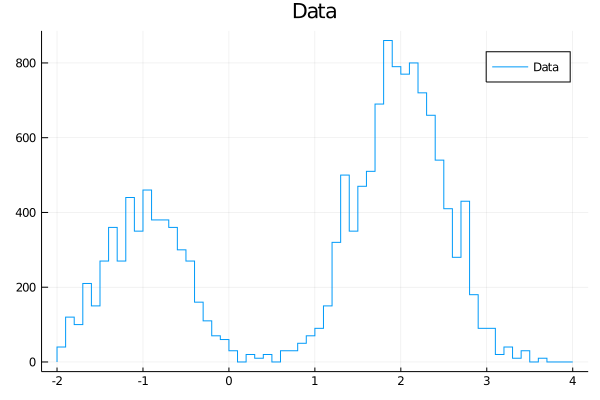

In [6]:
plot(
    normalize(hist, mode=:density),
    st = :steps, label = "Data",
    title = "Data"
)

Let's define our fit function - the function that we expect to describe the
data histogram, at each x-Axis position `x`, depending on a given set `p` of
model parameters:

In [7]:
function fit_function(p::NamedTuple{(:a, :mu, :sigma)}, x::Real)
    p.a[1] * pdf(Normal(p.mu[1], p.sigma), x) +
    p.a[2] * pdf(Normal(p.mu[2], p.sigma), x)
end

fit_function (generic function with 1 method)

The fit parameters (model parameters) `a` (peak areas) and `mu` (peak means)
are vectors, parameter `sigma` (peak width) is a scalar, we assume it's the
same for both Gaussian peaks.

The true values for the model/fit parameters are the values we used to
generate the data:

In [8]:
true_par_values = (a = [500, 1000], mu = (-1.0, 2.0), sigma = 0.5)

(a = [500, 1000], mu = (-1.0, 2.0), sigma = 0.5)

Let's visually compare the histogram and the fit function, using these true
parameter values, to make sure everything is set up correctly:

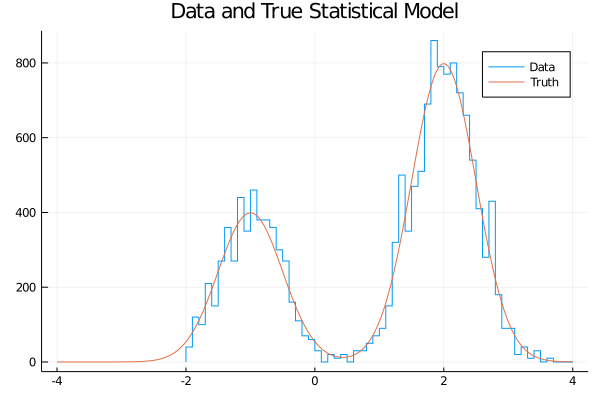

In [9]:
plot(
    normalize(hist, mode=:density),
    st = :steps, label = "Data",
    title = "Data and True Statistical Model"
)
plot!(
    -4:0.01:4, x -> fit_function(true_par_values, x),
    label = "Truth"
)

## Bayesian Fit

Now we'll perform a Bayesian fit of the generated histogram, using BAT,
to infer the model parameters from the data histogram.

In addition to the Julia packages loaded above, we need BAT itself, as
well as [IntervalSets](https://github.com/JuliaMath/IntervalSets.jl):

In [10]:
using BAT, IntervalSets

┌ Info: Precompiling BAT [c0cd4b16-88b7-57fa-983b-ab80aecada7e]
└ @ Base loading.jl:1273
┌ Warning: Package BAT does not have AdvancedHMC in its dependencies:
│ - If you have BAT checked out for development and have
│   added AdvancedHMC as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with BAT
└ Loading AdvancedHMC into BAT from project dependency, future warnings for BAT are suppressed.


### Likelihood Definition

First, we need to define the likelihood (function) for our problem.

BAT represents densities like likelihoods and priors as subtypes of
`BAT.AbstractDensity`. Custom likelihood can be defined by
creating a new subtype of `AbstractDensity` and by implementing (at minimum)
`BAT.density_logval` for that type - in complex uses cases, this may become
necessary. Typically, however, it is sufficient to define a custom
likelihood as a simple function that returns the log-likelihood value for
a given set of parameters. BAT will automatically convert such a
likelihood function into a subtype of `AbstractDensity`.

For performance reasons, functions should [not access global variables
directly] (https://docs.julialang.org/en/v1/manual/performance-tips/index.html#Avoid-global-variables-1).
So we'll use an [anonymous function](https://docs.julialang.org/en/v1/manual/functions/#man-anonymous-functions-1)
inside of a [let-statement](https://docs.julialang.org/en/v1/base/base/#let)
to capture the value of the global variable `hist` in a local variable `h`
(and to shorten function name `fit_function` to `f`, purely for
convenience). The likelihood function wraps it's result in a `LogDVal`
to indicate that it returns a log-likelihood value:

In [11]:
likelihood = let h = hist, f = fit_function
    params -> begin
        # Histogram counts for each bin as an array:
        counts = h.weights

        # Histogram binning, has length (length(counts) + 1):
        binning = h.edges[1]

        # sum log-likelihood value over bins:
        ll_value::Float64 = 0.0
        for i in eachindex(counts)
            # Get information about current bin:
            bin_left, bin_right = binning[i], binning[i+1]
            bin_width = bin_right - bin_left
            bin_center = (bin_right + bin_left) / 2

            observed_counts = counts[i]

            # Simple mid-point rule integration of fit function `f` over bin:
            expected_counts = bin_width * f(params, bin_center)

            # Add log of Poisson probability for bin:
            ll_value += logpdf(Poisson(expected_counts), observed_counts)
        end

        return LogDVal(ll_value)
    end
end

#9 (generic function with 1 method)

BAT makes use of Julia's parallel programming facilities if possible, e.g.
to run multiple Markov chains in parallel. Therefore, log-likelihood
(and other) code must be thread-safe. Mark non-thread-safe code with
`@critical` (provided by Julia package `ParallelProcessingTools`).

Support for automatic parallelization across multiple (local and remote)
Julia processes is planned, but not implemented yet.

Note that Julia currently starts only a single thread by default. Set the
the environment variable
[`JULIA_NUM_THREADS`](https://docs.julialang.org/en/v1/manual/environment-variables/#JULIA_NUM_THREADS-1)
to specify the desired number of Julia threads.

We can evaluate `likelihood`, e.g. for the true parameter values:

In [12]:
likelihood(true_par_values)

LogDVal{Float64}(-155.15303565581607)

### Prior Definition

Next, we need to choose a sensible prior for the fit:

In [13]:
using ValueShapes

prior = NamedTupleDist(
    a = [0.0..10.0^4, 0.0..10.0^4],
    mu = [-2.0..0.0, 1.0..3.0],
    sigma = Truncated(Normal(0.4, 2), 0.3, 0.7)
)

NamedTupleDist{(:a, :mu, :sigma),Tuple{Product{Continuous,Uniform{Float64},Array{Uniform{Float64},1}},Product{Continuous,Uniform{Float64},Array{Uniform{Float64},1}},Truncated{Normal{Float64},Continuous,Float64}},Tuple{ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ScalarShape{Real}}}}(
_internal_distributions: (a = Product{Continuous,Uniform{Float64},Array{Uniform{Float64},1}}(v=Uniform{Float64}[Uniform{Float64}(a=0.0, b=10000.0), Uniform{Float64}(a=0.0, b=10000.0)]), mu = Product{Continuous,Uniform{Float64},Array{Uniform{Float64},1}}(v=Uniform{Float64}[Uniform{Float64}(a=-2.0, b=0.0), Uniform{Float64}(a=1.0, b=3.0)]), sigma = Truncated(Normal{Float64}(μ=0.4, σ=2.0), range=(0.3, 0.7)))
_internal_shapes: NamedTupleShape{(:a, :mu, :sigma),Tuple{ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ScalarShape{Real}}}}((a = ValueAccessor{ArrayShape{Real,1}}(ArrayShape{Real,1}((2,)), 0, 2), mu = ValueAccessor{ArrayShape{Real,1}

In general, BAT allows instances of any subtype of `AbstractDensity` to
be uses as a prior, as long as a sampler is defined for it. This way, users
may implement complex application-specific priors. You can also
use `convert(AbstractDensity, distribution)` to convert any
continuous multivariate `Distributions.Distribution` to a
`BAT.AbstractDensity` that can be used as a prior (or likelihood).

The prior also implies the shapes of the parameters:

In [14]:
parshapes = varshape(prior)

NamedTupleShape{(:a, :mu, :sigma),Tuple{ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ScalarShape{Real}}}}((a = ValueAccessor{ArrayShape{Real,1}}(ArrayShape{Real,1}((2,)), 0, 2), mu = ValueAccessor{ArrayShape{Real,1}}(ArrayShape{Real,1}((2,)), 2, 2), sigma = ValueAccessor{ScalarShape{Real}}(ScalarShape{Real}(), 4, 1)), 5)

These will come in handy later on, e.g. to access (the posterior
distribution of) individual parameter values.

### Bayesian Model Definition

Given the likelihood and prior definition, a `BAT.PosteriorDensity` is simply
defined via

In [15]:
posterior = PosteriorDensity(likelihood, prior)

PosteriorDensity{BAT.GenericDensity{var"#9#10"{Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}},typeof(fit_function)}},BAT.DistributionDensity{NamedTupleDist{(:a, :mu, :sigma),Tuple{Product{Continuous,Uniform{Float64},Array{Uniform{Float64},1}},Product{Continuous,Uniform{Float64},Array{Uniform{Float64},1}},Truncated{Normal{Float64},Continuous,Float64}},Tuple{ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ScalarShape{Real}}}},BAT.HyperRectBounds{Float64}},BAT.HyperRectBounds{Float64},NamedTupleShape{(:a, :mu, :sigma),Tuple{ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ScalarShape{Real}}}}}(BAT.GenericDensity{var"#9#10"{Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}},typeof(fit_function)}}(var"#9#10"{Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}},

### Parameter Space Exploration via MCMC

We can now use Markov chain Monte Carlo (MCMC) to explore the space of
possible parameter values for the histogram fit.

To increase the verbosity level of BAT logging output, you may want to set
the Julia logging level for BAT to debug via `ENV["JULIA_DEBUG"] = "BAT"`.

In [16]:
ENV["JULIA_DEBUG"] = "BAT"

"BAT"

Let's use 4 MCMC chains and require 10^5 unique samples from each chain
(after tuning/burn-in):

In [17]:
nsamples = 10^4
nchains = 4

4

Now we can generate a set of MCMC samples via `bat_sample`:

In [18]:
samples = bat_sample(posterior, (nsamples, nchains), MetropolisHastings()).result
nothing # hide

┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Debug: Generating 32 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:211
┌ Debug: Testing 32 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:221
┌ Debug: Starting iteration over 32 MCMC chain(s)
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:242
┌ Debug: Starting iteration over MCMC chain 1, max_nsamples = 5, max_nsteps = 50, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 2, max_nsamples = 5, max_nsteps = 50, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 3, max_nsamples = 5, max_nsteps = 50, max_time = Inf
└ @ BAT /home/cornelius/Project

┌ Debug: Found 24 viable MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:235
┌ Debug: Starting iteration over 24 MCMC chain(s)
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:242
┌ Debug: Starting iteration over MCMC chain 1, max_nsamples = 25, max_nsteps = 250, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 3, max_nsamples = 25, max_nsteps = 250, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 4, max_nsamples = 25, max_nsteps = 250, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 5, max_nsamples = 25, max_nsteps = 250, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ 

┌ Debug: Found 24 MCMC chain(s) with at least 4 samples.
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:248
┌ Debug: Generating 32 additional MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:211
┌ Debug: Testing 32 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:221
┌ Debug: Starting iteration over 32 MCMC chain(s)
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:242
┌ Debug: Starting iteration over MCMC chain 33, max_nsamples = 5, max_nsteps = 50, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 34, max_nsamples = 5, max_nsteps = 50, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 35, max_nsamples = 5, max_nsteps = 50, max_time = Inf
└ @ BAT /ho

┌ Debug: Found 26 viable MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:235
┌ Debug: Starting iteration over 26 MCMC chain(s)
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:242
┌ Debug: Starting iteration over MCMC chain 33, max_nsamples = 25, max_nsteps = 250, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 34, max_nsamples = 25, max_nsteps = 250, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 35, max_nsamples = 25, max_nsteps = 250, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 36, max_nsamples = 25, max_nsteps = 250, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:20

┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Debug: Starting iteration over 4 MCMC chain(s)
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:242
┌ Debug: Starting iteration over MCMC chain 10, max_nsamples = 1000, max_nsteps = 10000, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 20, max_nsamples = 1000, max_nsteps = 10000, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 21, max_nsamples = 1000, max_nsteps = 10000, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_algorithm.jl:208
┌ Debug: Starting iteration over MCMC chain 36, max_nsamples = 1000, max_nsteps = 10000, max_time = Inf
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/mcmc_

┌ Debug: MCMC chain 10 *not* tuned, acceptance ratio = 0.0637, proposal scale = 0.33566815, max. log posterior = -173.17772
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/algorithms/mh_tuner.jl:126
┌ Debug: MCMC chain 20 *not* tuned, acceptance ratio = 0.1183012, proposal scale = 0.33566815, max. log posterior = -173.0981
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/algorithms/mh_tuner.jl:126
┌ Debug: MCMC chain 21 *not* tuned, acceptance ratio = 0.0469, proposal scale = 0.33566815, max. log posterior = -173.07832
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/algorithms/mh_tuner.jl:126
┌ Debug: MCMC chain 36 *not* tuned, acceptance ratio = 0.0971, proposal scale = 0.33566815, max. log posterior = -173.1034
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/algorithms/mh_tuner.jl:126
┌ Debug: Chains have converged, max(R^2) = 1.0359349210091604, threshold = 1.1
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/m

Let's calculate some statistics on the posterior samples:

In [19]:
println("Truth: $true_par_values")
println("Mode: $(mode(samples))")
println("Mean: $(mean(samples))")
println("Stddev: $(std(samples))")

Truth: (a = [500, 1000], mu = (-1.0, 2.0), sigma = 0.5)
Mode: ShapedAsNT((a = [502.08898192246323, 998.8655427788632], mu = [-0.9966884574334774, 2.0090133946875173], sigma = 0.48558811774529287))
Mean: ShapedAsNT((a = [504.1581569926207, 1000.5945207099292], mu = [-0.9947504405735471, 2.0095814997136885], sigma = 0.48837099969183634))
Stddev: ShapedAsNT((a = [22.85427185047219, 31.96334888235066], mu = [0.023915749560194533, 0.015435750473911], sigma = 0.009379968889688289))


Internally, BAT often needs to represent variates as flat real-valued
vectors:

In [20]:
unshaped.(samples).v

40000-element ArraysOfArrays.ArrayOfSimilarArrays{Float64,1,1,2,ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}}}:
 [526.7397242115268, 1012.6066401883611, -0.9583374039553062, 1.9887250906849254, 0.4899990090514088] 
 [473.75083681683606, 970.0671591181806, -0.9795110753694317, 1.990907136950135, 0.48100608532497185] 
 [523.4350001320086, 989.5980733479769, -0.9709688657215416, 2.0034971169199944, 0.489942330911112]   
 [520.6228409912067, 993.3944412252758, -0.9576442342181045, 1.9974766700980569, 0.4871957290962036]  
 [510.85195499419643, 1004.2504739097442, -0.9715989682303992, 2.0087513902946927, 0.4829054641922475]
 [503.51347955005855, 989.8192513442879, -0.9721934821498384, 2.0089080358875644, 0.4947896530369499] 
 [513.2335155217888, 1011.1194569310123, -0.9645669285924813, 2.021579399795982, 0.49153275734357016] 
 [503.18715773451976, 979.1799334838832, -0.9655203568616074, 2.0310550372675973, 0.487184160207235]  
 [503.9565387387563, 977.2934027022765, -0.9573975228

BAT uses [ValueShapes.jl](https://github.com/oschulz/ValueShapes.jl)
to implement a dual view of variate values in both shaped and unshaped form,
based on shape inferred from the prior and propagated to the posterior.
Shaped and unshaped samples are views of the same data in memory.
The variate/parameter shape can be accessed via

In [21]:
parshapes = varshape(posterior)

NamedTupleShape{(:a, :mu, :sigma),Tuple{ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ArrayShape{Real,1}},ValueAccessor{ScalarShape{Real}}}}((a = ValueAccessor{ArrayShape{Real,1}}(ArrayShape{Real,1}((2,)), 0, 2), mu = ValueAccessor{ArrayShape{Real,1}}(ArrayShape{Real,1}((2,)), 2, 2), sigma = ValueAccessor{ScalarShape{Real}}(ScalarShape{Real}(), 4, 1)), 5)

The statisics above (mode, mean and std-dev) are presented in shaped form.
However, it's not possible to represent statistics with matrix shape, e.g.
the parameter covariance matrix, this way. So the covariance has to be
accessed in unshaped form:

In [22]:
par_cov = cov(unshaped.(samples))
println("Covariance: $par_cov")

Covariance: [522.3177418152903 -5.164891419260855 -0.034856027171954004 0.0006739158432498708 0.015347125909209367; -5.164891419260855 1021.655671774853 -0.0022487035808653444 -0.0031132706111480306 -0.004260490309945567; -0.034856027171954004 -0.0022487035808653444 0.0005719630770259434 3.5987123799083603e-6 -3.216489834430953e-5; 0.0006739158432498708 -0.0031132706111480306 3.5987123799083603e-6 0.00023826239269284262 2.826094468907257e-7; 0.015347125909209367 -0.004260490309945567 -3.216489834430953e-5 2.826094468907257e-7 8.798381637152096e-5]


Our `parshapes` is a `NamedTupleShape`. It's properties (i.e. individual
parameter accessors) can be used as indices to query the covariance between
specific parameters:

In [23]:
par_cov[parshapes.mu, parshapes.sigma]

2-element ElasticArrays.ElasticArray{Float64,1,0,Array{Float64,1}}:
 -3.216489834430953e-5
  2.826094468907257e-7

### Visualization of Results

BAT.jl comes with an extensive set of plotting recipes for
["Plots.jl"] (http://docs.juliaplots.org/latest/).
We can plot the marginalized distribution for a single parameter (e.g.
parameter 3, i.e. μ[1]):

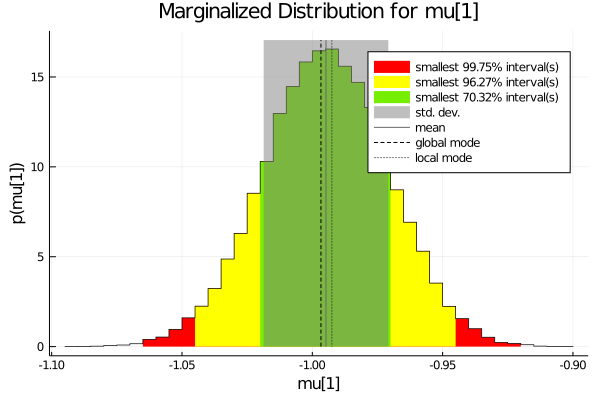

In [24]:
plot(
    samples, :(mu[1]),
    mean = true, std = true, globalmode = true, localmode = true,
    nbins = 50, title = "Marginalized Distribution for mu[1]"
)

or plot the marginalized distribution for a pair of parameters (e.g.
parameters 3 and 5, i.e. μ[1] and σ), including information from the parameter
stats:

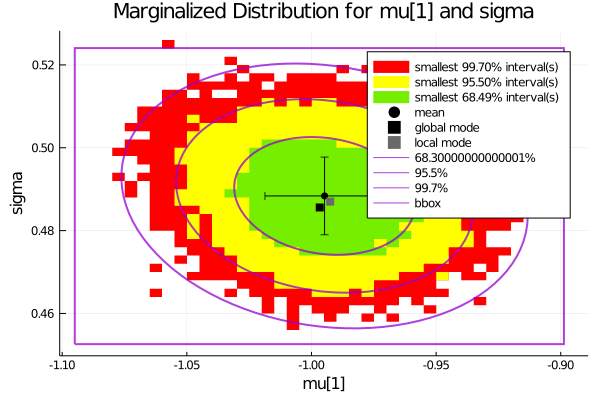

In [25]:
plot(
    samples, (:(mu[1]), :sigma),
    mean = true, std = true, globalmode = true, localmode = true,
    nbins = 50, title = "Marginalized Distribution for mu[1] and sigma"
)
plot!(BAT.MCMCBasicStats(samples), (3, 5))

We can also create an overview plot of the marginalized distribution for all
pairs of parameters:

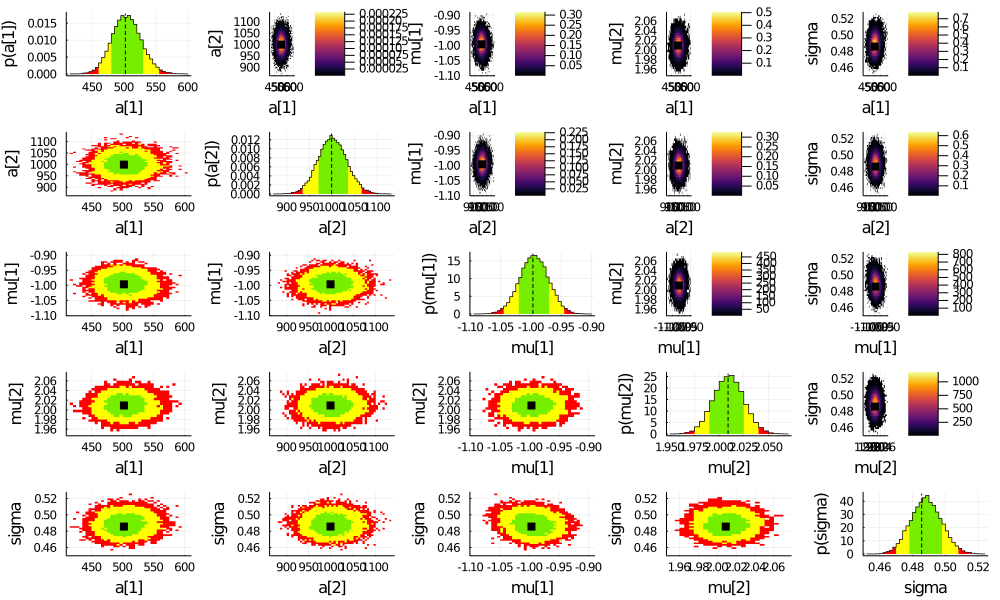

In [26]:
plot(
    samples,
    mean = false, std = false, globalmode = true, localmode = false,
    nbins = 50
)

### Integration with Tables.jl

`DensitySamplesVector` supports the
[Tables.jl](https://github.com/JuliaData/Tables.jl)
interface, so it is a table itself. We can also convert it to other table
types, e.g. a
[`TypedTables.Table`](http://blog.roames.com/TypedTables.jl/stable/):

In [27]:
using TypedTables

tbl = Table(samples)

ArgumentError: ArgumentError: Package TypedTables not found in current path:
- Run `import Pkg; Pkg.add("TypedTables")` to install the TypedTables package.


or a [`DataFrames.DataFrame`](https://github.com/JuliaData/DataFrames.jl),
etc.

## Comparison of Truth and Best Fit

As a final step, we retrieve the parameter values at the mode, representing
the best-fit parameters

In [28]:
samples_mode = mode(samples)

ShapedAsNT((a = [502.08898192246323, 998.8655427788632], mu = [-0.9966884574334774, 2.0090133946875173], sigma = 0.48558811774529287))

Like the samples themselves, the result can be viewed in both shaped and
unshaped form. `samples_mode` is presented as a 0-dimensional array that
contains a NamedTuple, this representation preserves the shape information:

In [29]:
samples_mode[] isa NamedTuple

unshaped(samples_mode)

5-element ElasticArrays.ElasticArray{Float64,1,0,Array{Float64,1}}:
 502.08898192246323   
 998.8655427788632    
  -0.9966884574334774 
   2.0090133946875173 
   0.48558811774529287

`samples_mode` is only an estimate of the mode of the posterior
distribution. It can be further refined using `bat_findmode`:

In [30]:
findmode_result = bat_findmode(posterior, initial_mode = samples_mode)

fit_par_values = findmode_result.result[]

(a = [502.7545720398502, 1000.0425663533063], mu = [-0.9949871127434217, 2.009455531546193], sigma = 0.4874632493059771)

Let's plot the data and fit function, for both true and best-fit parameter
values:

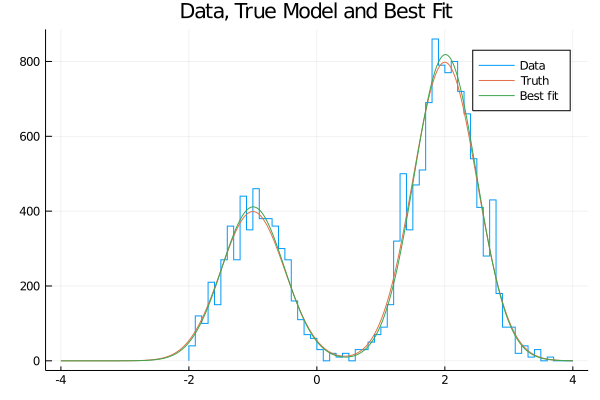

In [31]:
plot(
    normalize(hist, mode=:density),
    st = :steps, label = "Data",
    title = "Data, True Model and Best Fit"
)
plot!(-4:0.01:4, x -> fit_function(true_par_values, x), label = "Truth")
plot!(-4:0.01:4, x -> fit_function(fit_par_values, x), label = "Best fit")

## Fine-grained control

BAT provides fine-grained control over the MCMC algorithm options, the
MCMC chain initialization, tuning/burn-in strategy and convergence testing.
All option value used in the following are the default values, any or all
may be omitted.

We'll sample using the The Metropolis-Hastings MCMC algorithm:

In [32]:
algorithm = MetropolisHastings()

MetropolisHastings{BAT.MvTDistProposal,Int64,RepetitionWeighting{Int64}}(BAT.MvTDistProposal(1.0), RepetitionWeighting{Int64}())

BAT requires a counter-based random number generator (RNG), since it
partitions the RNG space over the MCMC chains. This way, a single RNG seed
is sufficient for all chains and results are reproducible even under
parallel execution. By default, BAT uses a Philox4x RNG initialized with a
random seed drawn from the
[system entropy pool](https://docs.julialang.org/en/v1/stdlib/Random/index.html#Random.RandomDevice):

In [33]:
using Random123
rng = Philox4x()

ArgumentError: ArgumentError: Package Random123 not found in current path:
- Run `import Pkg; Pkg.add("Random123")` to install the Random123 package.


Other default parameters are:

In [34]:
tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.35,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 8..128,
    max_nsamples_init = 25,
    max_nsteps_init = 250,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 1000,
    max_nsteps_per_cycle = 10000,
    max_time_per_cycle = Inf,
    max_ncycles = 30
)

MCMCBurninStrategy
  max_nsamples_per_cycle: Int64 1000
  max_nsteps_per_cycle: Int64 10000
  max_time_per_cycle: Float64 Inf
  max_ncycles: Int64 30


To generate MCMC samples with explicit control over all options, use

In [35]:
samples = bat_sample(
    rng, posterior, (nsamples, nchains), algorithm,
    max_nsteps = 10 * nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result
nothing # hide

UndefVarError: UndefVarError: rng not defined

However, in many use cases, simply using the default options via

```julia
samples = bat_sample(posterior, (nsamples, nchains), MetropolisHastings()).result
```

will often be sufficient.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*